# Functions

Calling functions - math functions, filter functions, etc. - are built in. This page takes you through some of the support in the current `hep_tables` package.

In [1]:
import sys
sys.path = ['..'] + sys.path
from hep_tables import xaod_table, make_local
from dataframe_expressions import user_func
from func_adl import EventDataset
import matplotlib.pyplot as plt

import numpy as np

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

In [2]:
dataset = EventDataset('localds://mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00')
df = xaod_table(dataset)

## Generic Math Functions

Python comes with a few math functions built in - that is, objects can directly support `abs` and the like. While only `abs` is implemented this way, you can see others that are possible in the [python documentation](https://docs.python.org/3/library/operator.html). The `abs` function already appeared in the previous page looking at filtering for the electron's `eta`. Here we do it a bit more simply:

In [3]:
%%time
eles = df.Electrons("Electrons")
np_eta_all = make_local(eles.eta)
np_eta_abs = make_local(abs(eles.eta))

Wall time: 5min 7s


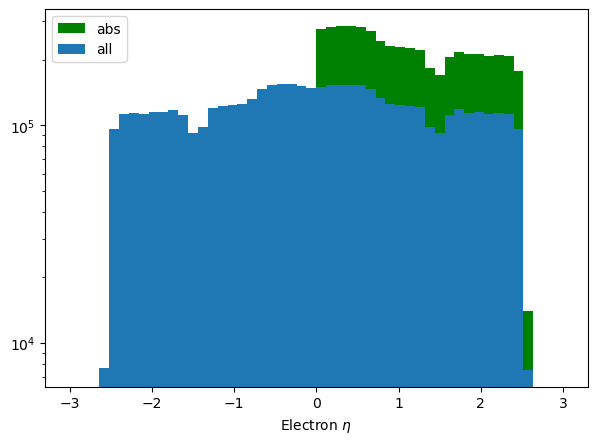

In [4]:
plt.hist(np_eta_abs.flatten(), label='abs', bins=50, range=(-3.0,3.0), color='g')
plt.hist(np_eta_all.flatten(), label='all', bins=50, range=(-3.0,3.0))
plt.yscale('log')
plt.xlabel('Electron $\eta$')
plt.legend();

## `numpy` integration

The `numpy` library is a defacto interface now. This section looks at two different integrations for `numpy`. This prototype is thinner here than normal - this is mainly here to understand what is possible.

### Math Functions

These include things like `np.sin` and `np.absolute` - here we do `np.abs` since it is one were the backend already works.

In [5]:
%%time
eles = df.Electrons("Electrons")
good_eles = eles[np.abs(eles.eta) < 2.5]
np_pts_good_short = make_local(good_eles.eta)

Wall time: 2min 22s


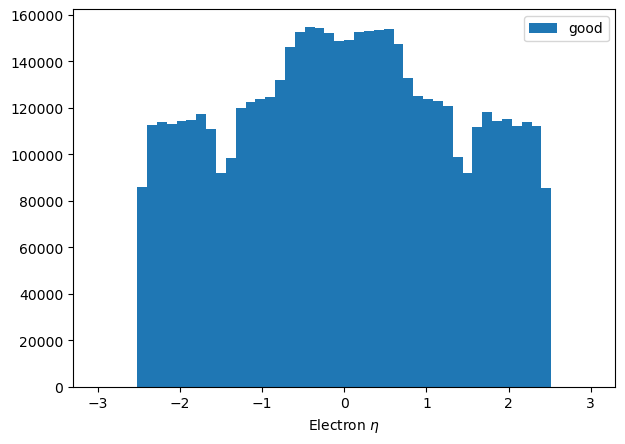

In [6]:
plt.hist(np_pts_good_short.flatten(), label='good', bins=50, range=(-3.0,3.0))
plt.xlabel("Electron $\eta$")
plt.legend();

### Histograms

The basis for many plots we do in particle physics is the histogram. When it comes down to it, in Run 4+, it is not likely we can run this locally - we'll need to run it remotely. Unfortunately, `numpy` doesn't use the above extension mechanism for `numpy.histogram` - so we have to re-write it. This is what it might look like:

In [7]:
from hep_tables import histogram

In [8]:
good_eles = eles[np.abs(eles.eta) < 2.5]
good_ele_hist = make_local(histogram(good_eles.eta, bins=50, range=(-3.0,3.0)))

In [9]:
good_ele_hist

(array([     0,      0,      0,      0,  85745, 112741, 113874, 112983,
        114508, 114784, 117134, 110956,  91870,  98522, 119778, 122264,
        123661, 124620, 132150, 146337, 152674, 154650, 154280, 151966,
        148552, 149257, 152511, 152984, 153445, 153742, 147485, 132846,
        125098, 123592, 123053, 120665,  98664,  91761, 111661, 118223,
        114385, 114995, 112068, 113957, 112241,  85682,      0,      0,
             0,      0], dtype=int64),
 array([-3.  , -2.88, -2.76, -2.64, -2.52, -2.4 , -2.28, -2.16, -2.04,
        -1.92, -1.8 , -1.68, -1.56, -1.44, -1.32, -1.2 , -1.08, -0.96,
        -0.84, -0.72, -0.6 , -0.48, -0.36, -0.24, -0.12,  0.  ,  0.12,
         0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,  0.96,  1.08,  1.2 ,
         1.32,  1.44,  1.56,  1.68,  1.8 ,  1.92,  2.04,  2.16,  2.28,
         2.4 ,  2.52,  2.64,  2.76,  2.88,  3.  ]))

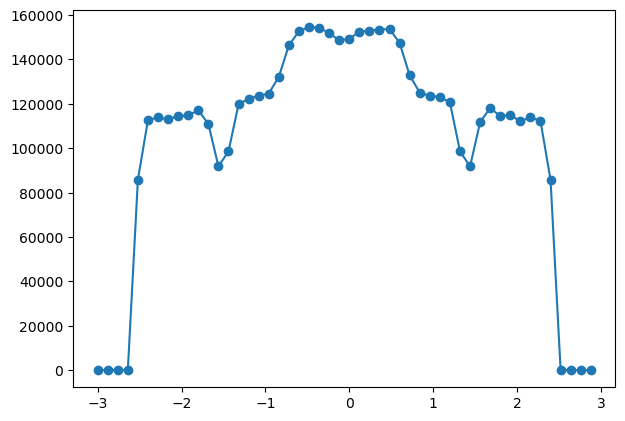

In [10]:
plt.plot(good_ele_hist[1][:-1], good_ele_hist[0], marker='o')

Here is what happened - since the `servicex` transformer we are talking to can't actually fill a histogram.

1. `make_local` picked off the data that needed to be histogramed, and shipped it off to `servicex` as normal
1. It then uses the real `np.histogram` to fill a histogram, and packaged up the results
1. And then shipped those back to the user.
1. I demonstrated how badly I know `matplotlib` with that aweful looking histogram rather than understanding how to use `matplotlibs`'s `hist`.

Other than the plotting, these instructions are in the DAQ before `make_local` is called - so could easily be shipped to a remote analysis facility. And one would imagine the histogram data being shipped in a more transportable format, like [`aghast`](https://github.com/scikit-hep/aghast).

## The `map` function

The `map` function is a common function that takes a sequence of values, like $seq = (x_0, x_1, x_2, x_3,...)$ and a single argument function like `f(x)`, and applies them such that $map(f, seq) = (f(x_0), f(x_1), f(x_2), f(x_3), ...)$. In many places this `map` function has been effectively used already. For example, `ele_pt = df.eles.pt` could be written as:

```
df.eles.map(lambda e: e.pt)
```

This function is explicitly implemented in this prototype:

In [11]:
mapped_eles = eles.map(lambda e: e.pt/1000.0)

In [12]:
%%time
mapped_eles_pt = make_local(mapped_eles)

Wall time: 2min 7s


i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


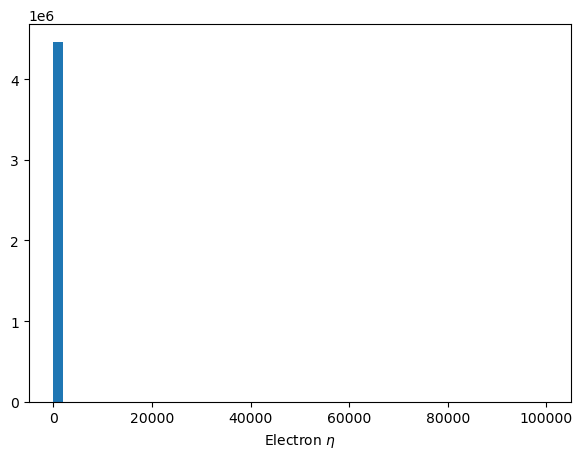

In [13]:
plt.hist(mapped_eles_pt.flatten(), bins=50, range=(0, 100000.0))
_ = plt.xlabel('Electron $\eta$')

Now that the concept is down, much more complex things are possible inside that `lambda`. And there is no need for it to be a `lambda` - it can be a normal function as long as it returns a calculated DAQ expressions (so no if statements on data, etc.). The real power of this will be seen when we look at multiple objects in one expression later on.

## Backend Functions

There are times one wants to use a stand-alone function that is availible at the backend. This is one example of a leaky abstraction. `hep_tables` uses a fairly simple syntax to declare a function like this. For example, in the current ATLAS `xAOD` `servicex` transformer the `DeltaR` function is declared:

In [14]:
@user_func
def DeltaR(p1_eta: float, p1_phi: float, p2_eta: float, p2_phi: float) -> float:
    '''
    Calculate the DeltaR between two particles given their `eta` and `phi` locations.
    Implemented on the back end.
    '''
    assert False, 'This should never be called'

The type hints isn't required, I'm trying to be better. The decorator `user_func` declares it to the system as a function that should be called on the back end. We can now use it - although in a rather boring way:

In [15]:
mapped_eles = eles.map(lambda e: DeltaR(e.eta, e.phi, e.eta, e.phi))

In [16]:
%%time
delta_r_zero = make_local(mapped_eles)
delta_r_zero

Wall time: 2min 7s


<JaggedArray [[0.0] [0.0 0.0 0.0 0.0] [] ... [0.0] [0.0 0.0 0.0] []] at 0x013f00099cc8>

There is one architectural decision I made here - not at all sure it is the right one. But lets say we have $seq = (x_0, x_1, x_2, x_3,...)$ as before. Then `abs(seq)` is translated into the mathmatical equivalent of `seq.map(lambda s: abs(s))`. That does not happen for `user_func`'s. The reason is I'm not at all sure what is the right thing to do when two different sequences are passed to `DeltaR`. Instead, in the prototype this has been made explicit. One can always write helper functions and compose them, of course.

As a side note, it might be interesting to combine this with some of the `numpy.histogram` like methods to implement them on the backend.